In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
#Cargar base de datos integrada que contiene las variables concideradas boya calidad de agua y estación Meteorologica 
bd_integrada = pd.read_excel("bd_integrada.xlsx")
len(bd_integrada)

10665

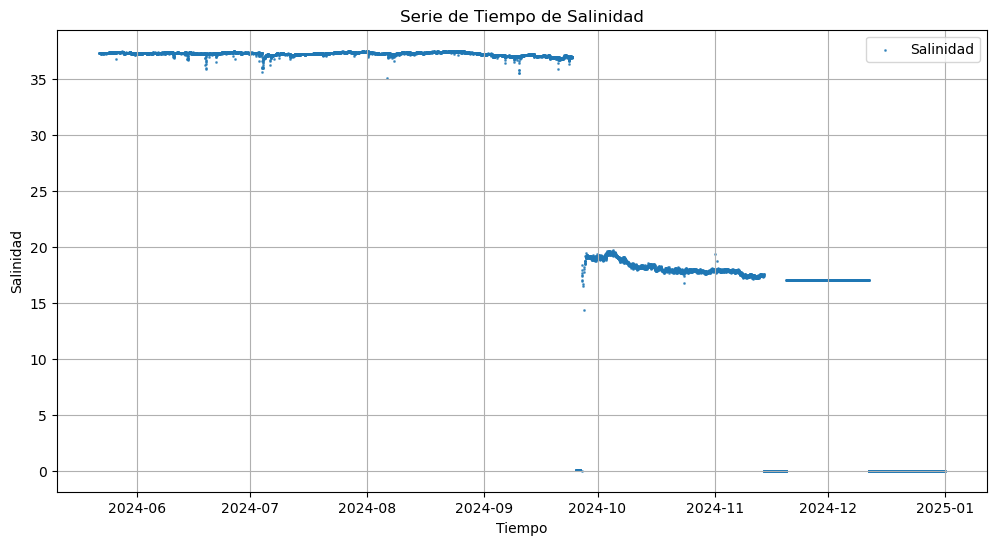

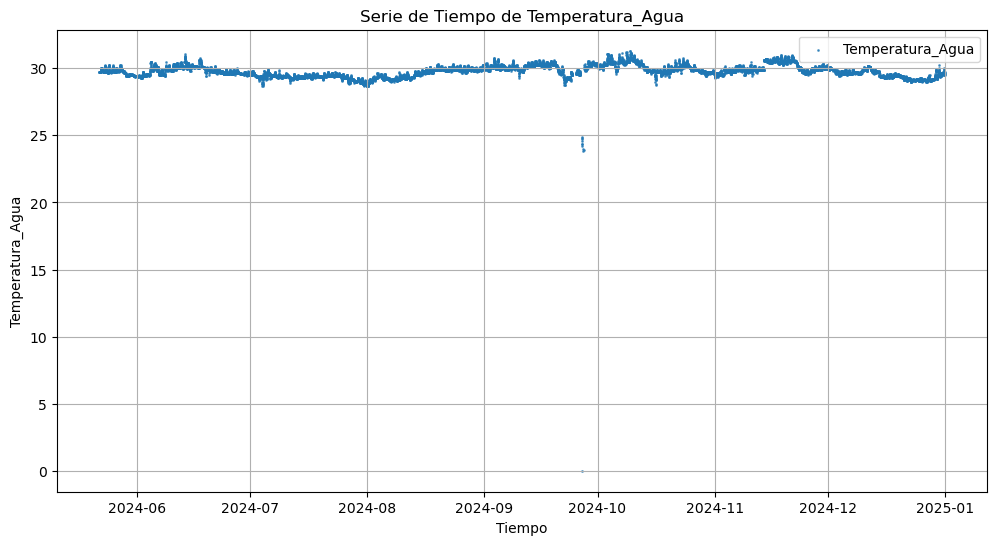

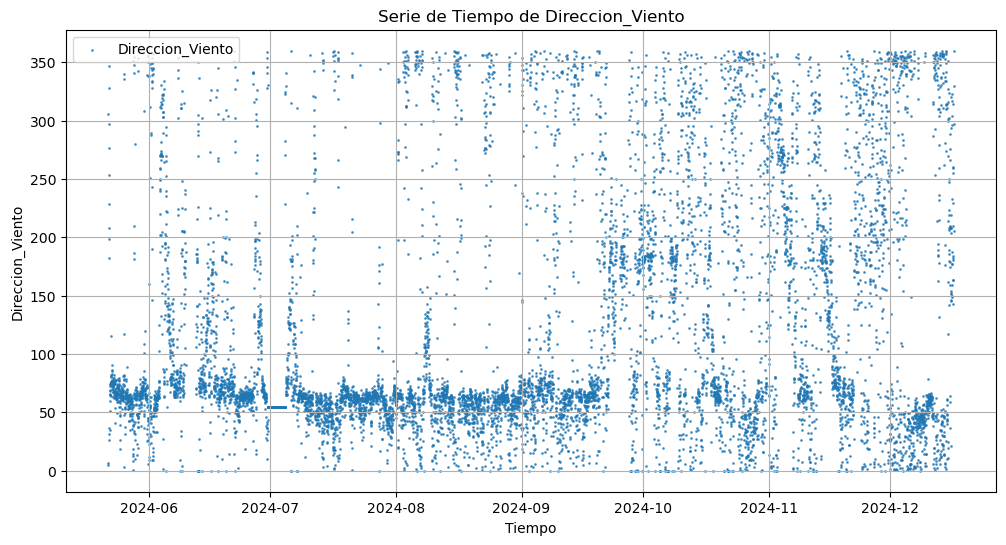

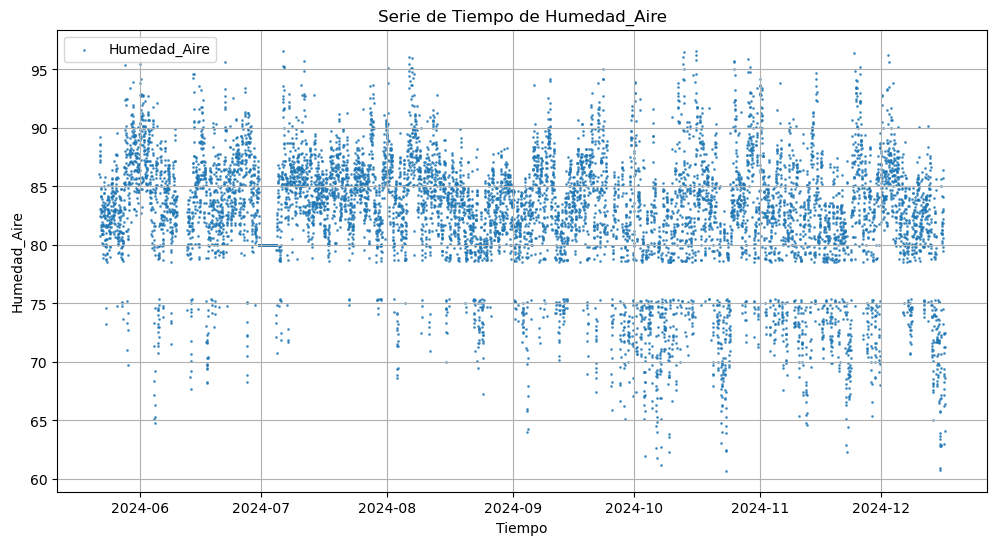

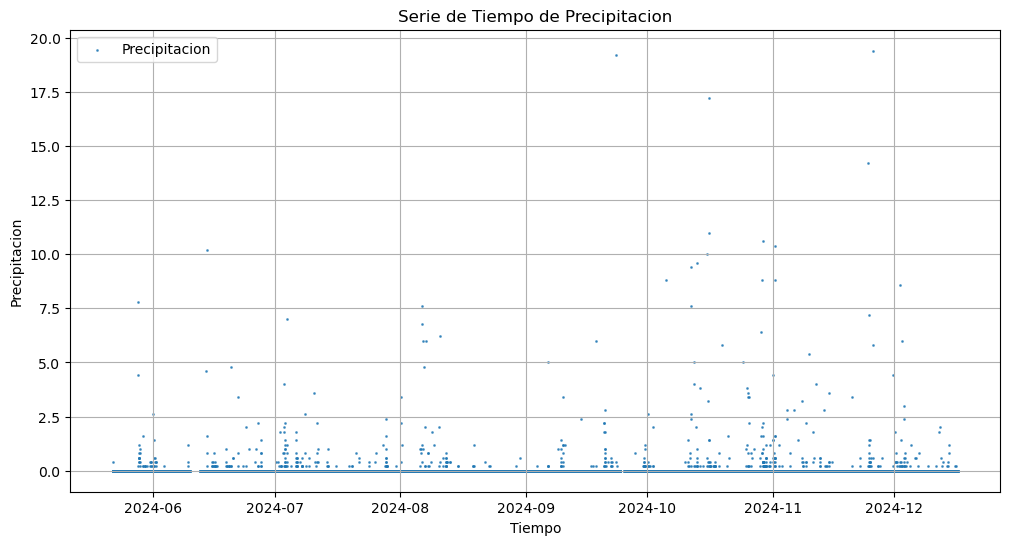

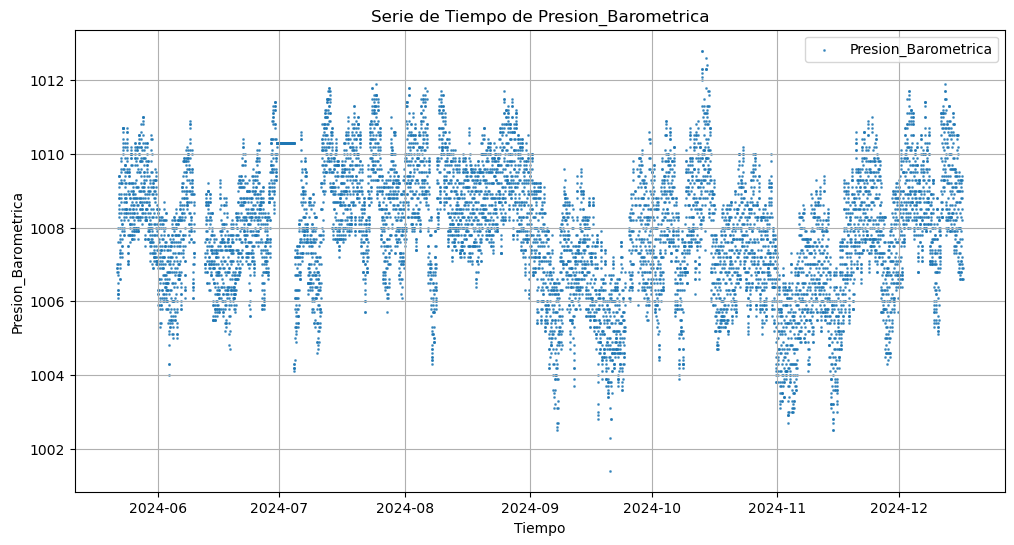

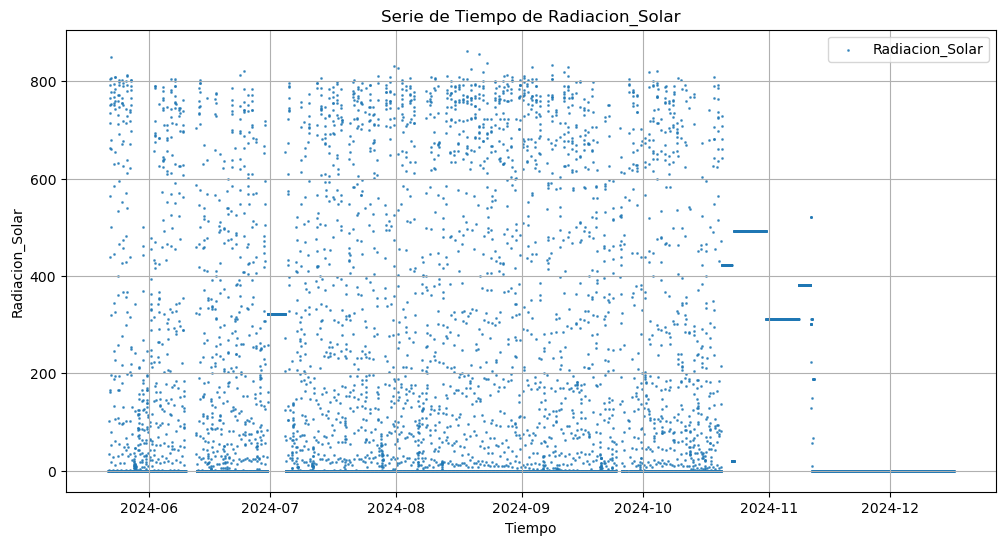

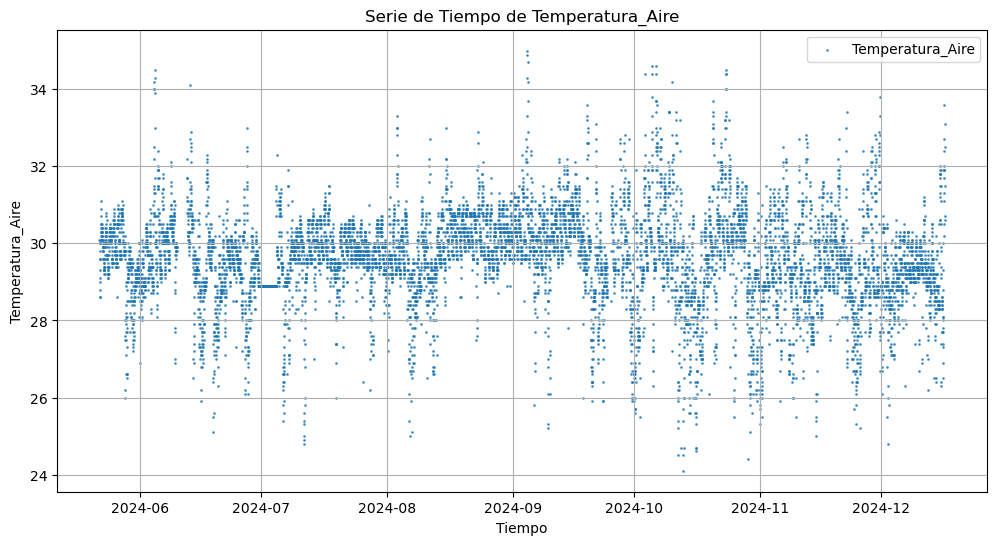

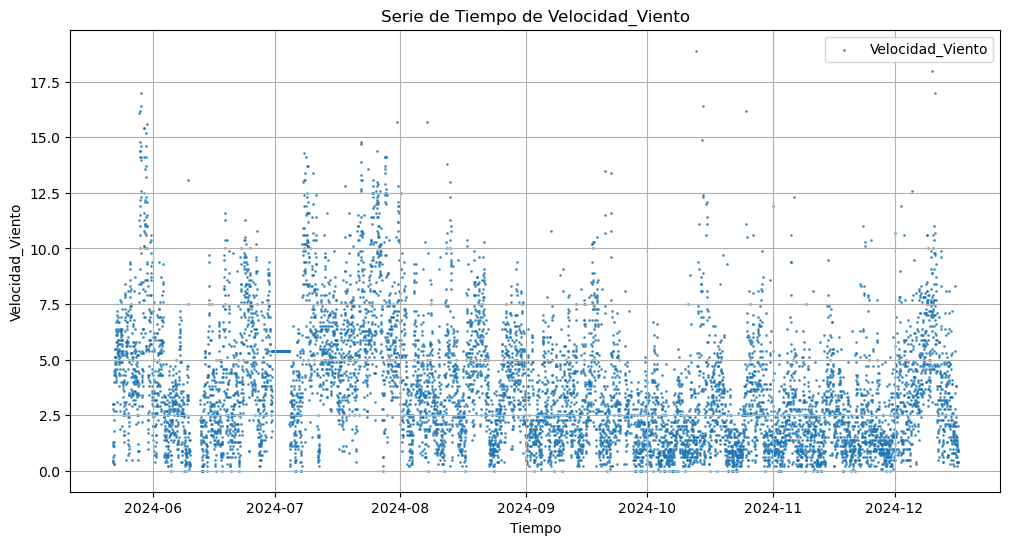

In [3]:
#Un primer vistazo para explorar las variables 
# Convertir la columna de tiempo a tipo datetime
bd_integrada['Tiempo'] = pd.to_datetime(bd_integrada['Tiempo'])

# Graficar cada variable individualmente con puntos muy pequeños
for column in bd_integrada.columns[1:]:  # Omitir la columna de tiempo
    plt.figure(figsize=(12, 6))
    plt.scatter(bd_integrada['Tiempo'], bd_integrada[column], s=1, alpha=0.7, label=column)  # Puntos más pequeños
    plt.xlabel('Tiempo')
    plt.ylabel(column)
    plt.title(f'Serie de Tiempo de {column}')
    plt.legend()
    plt.grid(True)
    plt.show()

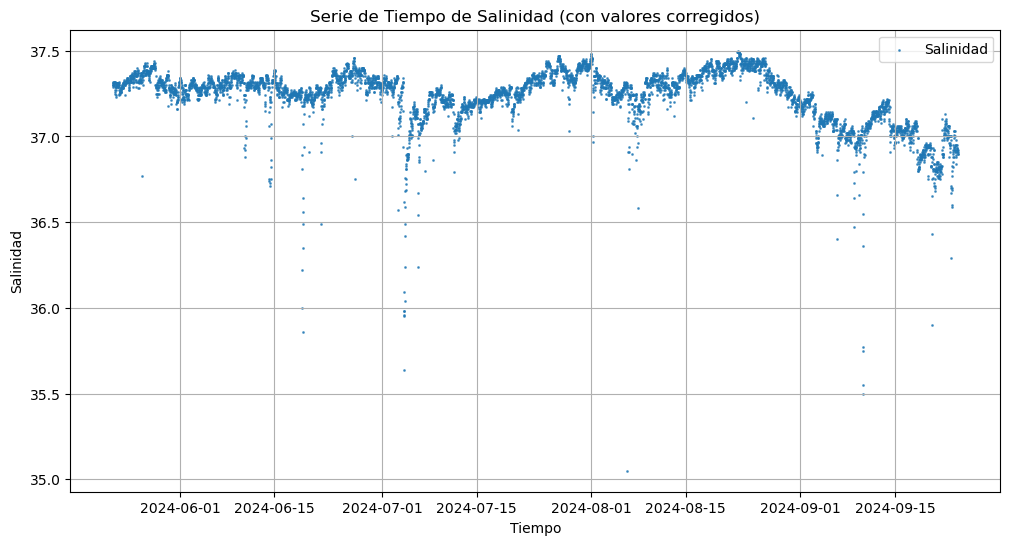

In [4]:
#Debido a la falta de datos relizaremos el ananlisis a nivel univariado para la imputacion de datos. 

# Reemplazar valores de Salinidad menores a 25 con NaN  
bd_integrada.loc[bd_integrada['Salinidad'] < 25, 'Salinidad'] = np.nan

# Graficar la serie de tiempo de Salinidad con los valores corregidos
plt.figure(figsize=(12, 6))
plt.scatter(bd_integrada['Tiempo'], bd_integrada['Salinidad'], s=1, alpha=0.7, label='Salinidad')
plt.xlabel('Tiempo')
plt.ylabel('Salinidad')
plt.title('Serie de Tiempo de Salinidad (con valores corregidos)')
plt.legend()
plt.grid(True)
plt.show()



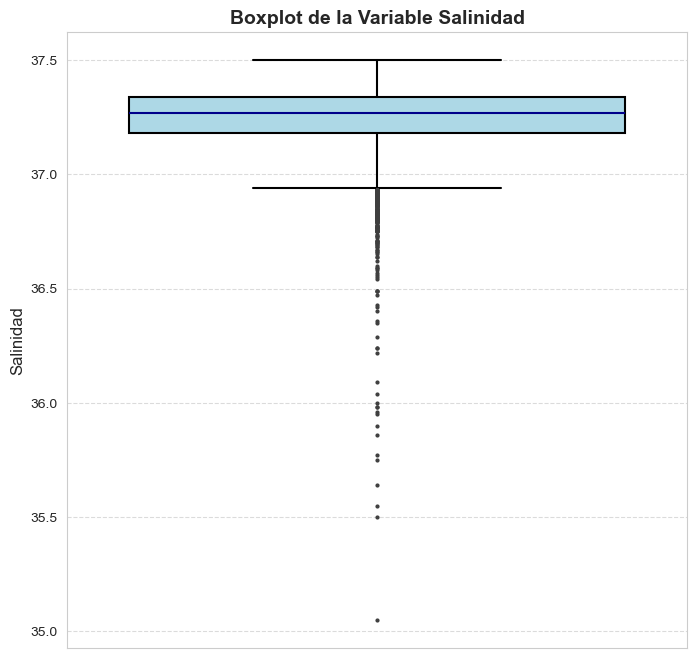

In [5]:
#Graficamos un boxplot para explorar graficamente si hay valores atipicos. 


# Establecer el estilo de la gráfica
sns.set_style("whitegrid")

# Crear la figura
plt.figure(figsize=(8, 8))

# Graficar el boxplot 
sns.boxplot(
    y=bd_integrada['Salinidad'].dropna(),
    boxprops=dict(facecolor="lightblue", edgecolor="black"),  
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="darkblue"),
    flierprops=dict(marker='o', color='blue', markersize=2)  
)

# Títulos y etiquetas
plt.title('Boxplot de la Variable Salinidad', fontsize=14, fontweight='bold')
plt.ylabel('Salinidad', fontsize=12)
plt.xticks([])  # Eliminar etiquetas del eje x para más limpieza
plt.grid(axis='y', linestyle="--", alpha=0.7)  # Líneas de referencia más sutiles

# Mostrar el gráfico
plt.show()



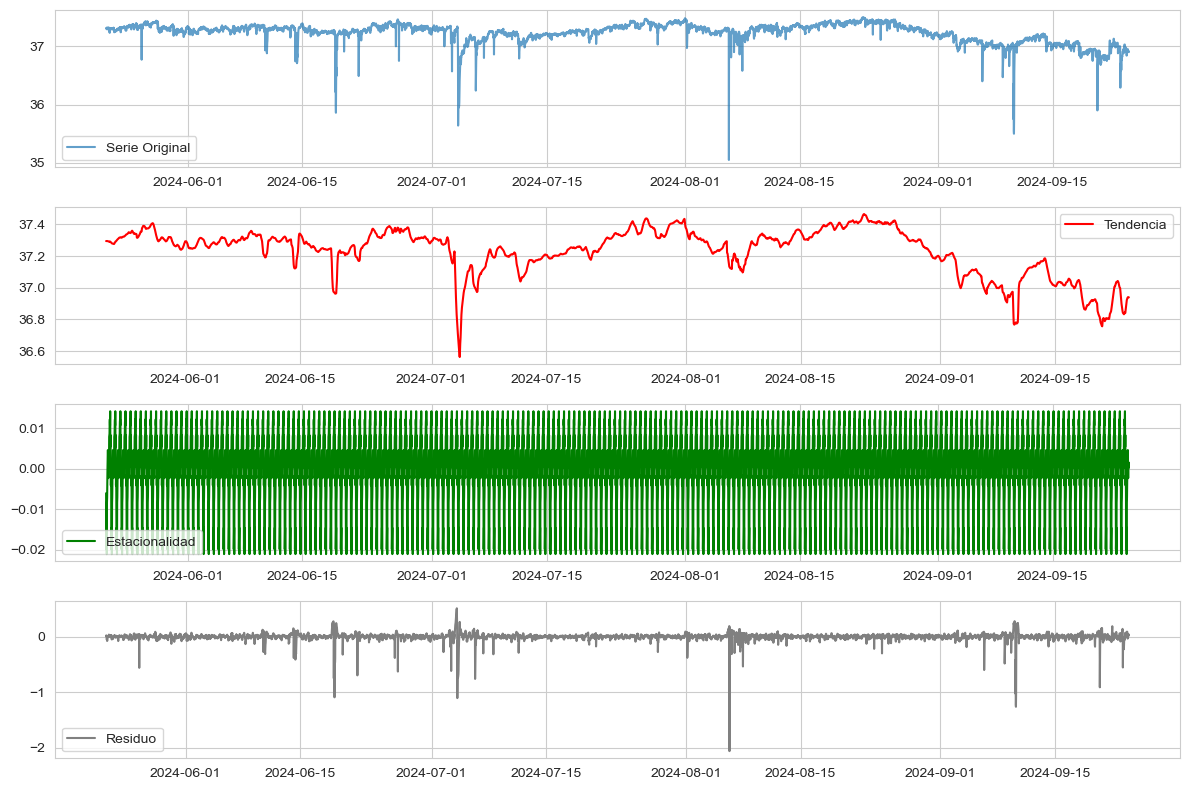

In [6]:


# Aplicar la descomposición de la serie temporal (modelo aditivo)
decomposition = seasonal_decompose(bd_integrada['Salinidad'].dropna(), model='additive', period=30)  # Suponemos un ciclo mensual

# Graficar la descomposición
plt.figure(figsize=(12, 8))

# Gráfico de la serie original
plt.subplot(4, 1, 1)
plt.plot(bd_integrada['Tiempo'], bd_integrada['Salinidad'], label='Serie Original', alpha=0.7)
plt.legend()
plt.grid(True)

# Gráfico de la tendencia
plt.subplot(4, 1, 2)
plt.plot(bd_integrada['Tiempo'].iloc[:len(decomposition.trend)], decomposition.trend, label='Tendencia', color='red')
plt.legend()
plt.grid(True)

# Gráfico de la estacionalidad
plt.subplot(4, 1, 3)
plt.plot(bd_integrada['Tiempo'].iloc[:len(decomposition.seasonal)], decomposition.seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.grid(True)

# Gráfico del residuo
plt.subplot(4, 1, 4)
plt.plot(bd_integrada['Tiempo'].iloc[:len(decomposition.resid)], decomposition.resid, label='Residuo', color='gray')
plt.legend()
plt.grid(True)

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


In [7]:
# Usaremos la implementación de la prueba de Mann-Kendall desde scipy
import scipy.stats as stats
import numpy as np

# Crear una serie temporal sin NaN
salinidad_no_nan = bd_integrada['Salinidad'].dropna().values

# Calcular la prueba de Mann-Kendall
n = len(salinidad_no_nan)
s = 0

# Calcular la estadística S
for i in range(n - 1):
    for j in range(i + 1, n):
        s += np.sign(salinidad_no_nan[j] - salinidad_no_nan[i])

# Calcular la varianza de S
var_s = (n * (n - 1) * (2 * n + 5)) / 18

# Calcular el estadístico Z
if s > 0:
    z = (s - 1) / np.sqrt(var_s)
elif s < 0:
    z = (s + 1) / np.sqrt(var_s)
else:
    z = 0

# Calcular el p-valor
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

# Mostrar resultados
z, p_value


(-25.371407247812396, 0.0)

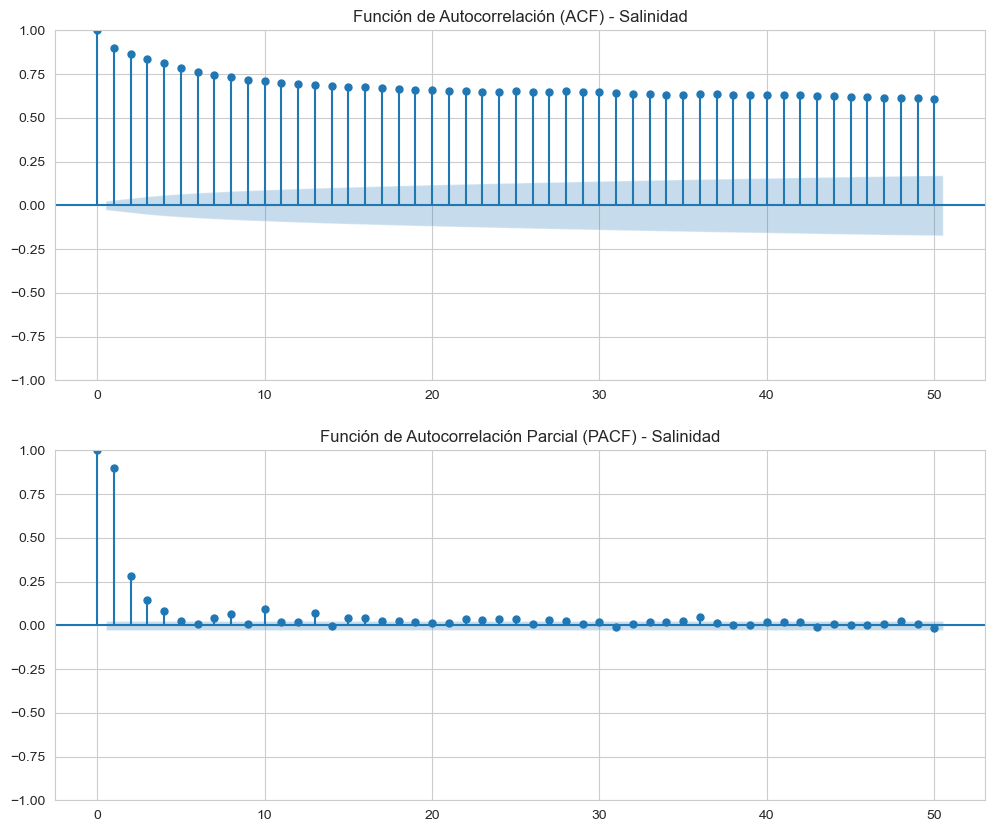

In [8]:


# Configurar el tamaño de las figuras
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de Autocorrelación (ACF)
plot_acf(bd_integrada['Salinidad'].dropna(), ax=ax[0], lags=50, alpha=0.05)
ax[0].set_title('Función de Autocorrelación (ACF) - Salinidad')

# Gráfico de Autocorrelación Parcial (PACF)
plot_pacf(bd_integrada['Salinidad'].dropna(), ax=ax[1], lags=50, alpha=0.05)
ax[1].set_title('Función de Autocorrelación Parcial (PACF) - Salinidad')

# Mostrar los gráficos
plt.show()


In [9]:


# Aplicar la prueba de Dickey-Fuller Aumentada (ADF) a la serie de Salinidad
adf_test = adfuller(bd_integrada['Salinidad'].dropna())

# Extraer los resultados
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]  # Valores críticos para diferentes niveles de significancia

# Mostrar los resultados
adf_statistic, p_value, critical_values


(-4.123220136370649,
 0.0008863822555686271,
 {'1%': -3.4314421710435847,
  '5%': -2.8620226390585444,
  '10%': -2.5670269063352666})